
## Understanding Embedding Models and Similarity

<a href="https://colab.research.google.com/github/adithya-s-k/AI-Engineering.academy/blob/main/RAG/00_RAG_from_Scratch/Understanding_embeddings_and_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q sentence-transformers
!pip install -q wikipedia-api
!pip install -q numpy
!pip install -q scipy
!pip install rich
!pip install pypdf2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 6.9 MB/s eta 0:00:00


In [2]:
import re
import os
from rich import print
from sentence_transformers import SentenceTransformer
import numpy as np
import textwrap
from IPython.display import display, HTML

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Load Data

In [6]:
from wikipediaapi import Wikipedia
wiki = Wikipedia('RAGBot/0.0', 'en')
data = wiki.page('Hayao_Miyazaki').text

## After Uploading a pdf
# data = load_document("/content/R_Tamil_LLama.pdf")

print(data)

Hayao Miyazaki (宮崎 駿 or 宮﨑 駿, Miyazaki Hayao, ; born January 5, 1941) is a Japanese animator, filmmaker, and 
manga artist. A founder of Studio Ghibli, he has attained international acclaim as a masterful storyteller and 
creator of Japanese animated feature films, and is widely regarded as one of the most accomplished filmmakers in 
the history of animation.
Born in Tokyo City, Miyazaki expressed interest in manga and animation from an early age. He joined Toei Animation 
in 1963, working as an inbetween artist and key animator on films like Gulliver's Travels Beyond the Moon (1965), 
Puss in Boots (1969), and Animal Treasure Island (1971), before moving to A-Pro in 1971, where he co-directed Lupin
the Third Part I (1971–1972) alongside Isao Takahata. After moving to Zuiyō Eizō (later Nippon Animation) in 1973, 
Miyazaki worked as an animator on World Masterpiece Theater and directed the television series Future Boy Conan 
(1978). He joined Tokyo Movie Shinsha in 1979 to direct his first feature film The Castle of Cagliostro (1979) and 
the television series Sherlock Hound (1984–1985). He wrote and illustrated the manga Nausicaä of the Valley of the 
Wind (1982–1994) and directed the 1984 film adaptation produced by Topcraft.
Miyazaki co-founded Studio Ghibli in 1985, writing and directing films such as Laputa: Castle in the Sky (1986), My
Neighbor Totoro (1988), Kiki's Delivery Service (1989), and Porco Rosso (1992), which were met with critical and 
commercial success in Japan. Miyazaki's Princess Mononoke (1997) was the first animated film to win the Japan 
Academy Film Prize for Picture of the Year and briefly became the highest-grossing film in Japan; its Western 
distribution increased Ghibli's worldwide popularity and influence. Spirited Away (2001) became Japan's 
highest-grossing film and won the Academy Award for Best Animated Feature; it is frequently ranked among the 
greatest films of the 21st century. Miyazaki's later films—Howl's Moving Castle (2004), Ponyo (2008), and The Wind 
Rises (2013)—also enjoyed critical and commercial success. He retired from feature films in 2013 but later returned
to make The Boy and the Heron (2023), which won the Academy Award for Best Animated Feature.
Miyazaki's works are frequently subject to scholarly analysis and have been characterized by the recurrence of 
themes such as humanity's relationship with nature and technology, the importance of art and craftsmanship, and the
difficulty of maintaining a pacifist ethic in a violent world. His protagonists are often strong girls or young 
women, and several of his films present morally ambiguous antagonists with redeeming qualities. Miyazaki's works 
have been highly praised and awarded; he was named a Person of Cultural Merit for outstanding cultural 
contributions in 2012, and received the Academy Honorary Award for his impact on animation and cinema in 2014. 
Miyazaki has frequently been cited as an inspiration for numerous animators, directors, and writers.

Early life
Hayao Miyazaki was born on January 5, 1941, in the town Akebono-cho in Hongō, Tokyo City, Empire of Japan, the 
second of four sons. His father, Katsuji Miyazaki (born 1915), was the director of Miyazaki Airplane, his brother's
company, which manufactured rudders for fighter planes during World War II. The business allowed his family to 
remain affluent during Miyazaki's early life. Miyazaki's father enjoyed purchasing paintings and demonstrating them
to guests, but otherwise had little known artistic understanding. He was in the Imperial Japanese Army around 1940,
discharged and lectured about disloyalty after declaring to his commanding officer that he wished not to fight 
because of his wife and young child. According to Miyazaki, his father often told him about his exploits, claiming 
he continued to attend nightclubs after turning 70. Katsuji Miyazaki died on March 18, 1993. After his death, 
Miyazaki felt he had often looked at his father negatively and tha

Perform Chunking

In [4]:
def chunk_text(text, chunk_size=1000, overlap=20):
    """
    Split the text into chunks based on the number of words and word overlap.
    """
    words = text.split()
    chunks = []
    for i in range(0, len(words), chunk_size - overlap):
        chunk = ' '.join(words[i:i + chunk_size])
        chunks.append(chunk)
    return chunks

chunked_data = chunk_text(data)

print("Total number of chunks", len(chunked_data))

Total number of chunks 11

Visualise Chunking

In [5]:
def print_chunks(chunks):
    """
    Display text chunks in a clean, readable format using HTML styling.

    Args:
        chunks (list): List of text chunks to display
    """
    # Create the HTML for the chunks display
    html_content = """
    <style>
        .chunk-container {
            font-family: Arial, sans-serif;
            margin: 20px 0;
        }
        .chunk-header {
            background-color: #f0f2f6;
            padding: 5px 10px;
            border-radius: 5px 5px 0 0;
            border-left: 4px solid #3498db;
            font-weight: bold;
            color: #2c3e50;
        }
        .chunk-content {
            background-color: #ffffff;
            color: #2c3e50;
            padding: 10px;
            border: 1px solid #e1e4e8;
            border-left: 4px solid #3498db;
            border-top: none;
            border-radius: 0 0 5px 5px;
            white-space: pre-wrap;
            font-family: monospace;
        }
    </style>
    """

    # Add each chunk to the HTML content
    for i, chunk in enumerate(chunks, 1):
        # Wrap text for better readability
        wrapped_text = textwrap.fill(chunk, width=100)

        html_content += f"""
        <div class="chunk-container">
            <div class="chunk-header">Chunk {i}</div>
            <div class="chunk-content">{wrapped_text}</div>
        </div>
        """

    # Display the HTML
    display(HTML(html_content))
print_chunks(chunked_data)

Setting Up embedding model

In [7]:
# Load the sentence transformer model for embeddings

model = SentenceTransformer("Alibaba-NLP/gte-base-en-v1.5", trust_remote_code=True)
# model = SentenceTransformer("BAAI/bge-small-en-v1.5", trust_remote_code=True)
# model = SentenceTransformer("all-MiniLM-L6-v2", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

configuration.py:   0%|          | 0.00/7.13k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- configuration.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling.py:   0%|          | 0.00/59.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/547M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

set up similarity function


Understanding Cosine Similarity : [refrence video](https://www.youtube.com/watch?v=zcUGLp5vwaQ)

In [8]:
def cosine_similarity(vector_a, vector_b):
    """
    Calculate the cosine similarity between two vectors.
    Cosine similarity measures how similar two vectors are by calculating the cosine of the angle between them.

    Args:
        vector_a: First vector (numpy array)
        vector_b: Second vector (numpy array)

    Returns:
        float: Similarity score between -1 and 1
               1: Vectors are identical
               0: Vectors are perpendicular
              -1: Vectors are opposite
    """
    # Step 1: Calculate the dot product between the vectors
    # Dot product measures how much vectors point in the same direction
    dot_product = np.dot(vector_a, vector_b)

    # Step 2: Calculate the magnitude (length) of each vector
    # Magnitude is the square root of the sum of squared values
    magnitude_a = np.linalg.norm(vector_a)  # √(a1² + a2² + ... + an²)
    magnitude_b = np.linalg.norm(vector_b)  # √(b1² + b2² + ... + bn²)

    # Step 3: Calculate the cosine similarity
    # Divide dot product by the product of magnitudes
    similarity = dot_product / (magnitude_a * magnitude_b)

    return similarity

understanding similarity between two sentences

In [9]:
## Change the sentences accordingly

sentence1 = "The cat sat on the mat"
sentence2 = "A cat is sitting on a mat"

In [10]:
def get_similarity_score(sentence1, sentence2):
    """
    Calculate similarity score between two sentences.

    Args:
        sentence1 (str): First sentence
        sentence2 (str): Second sentence

    Returns:
        float: Similarity score between 0 and 1
    """
    # Get embeddings
    embedding1 = model.encode(sentence1, normalize_embeddings=True)
    embedding2 = model.encode(sentence2, normalize_embeddings=True)

    # Calculate similarity
    similarity = cosine_similarity(embedding1, embedding2)

    return similarity

# change the sentences


score = get_similarity_score(sentence1, sentence2)
print(f"Similarity score: {score:.4f}")

Similarity score: 0.9067

visualise embeddings

Similarity Score: 0.9067

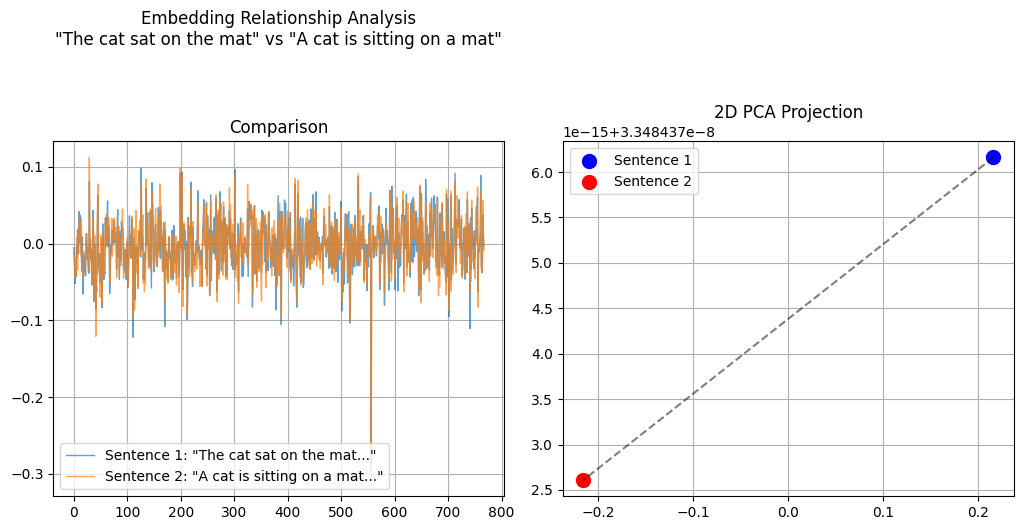

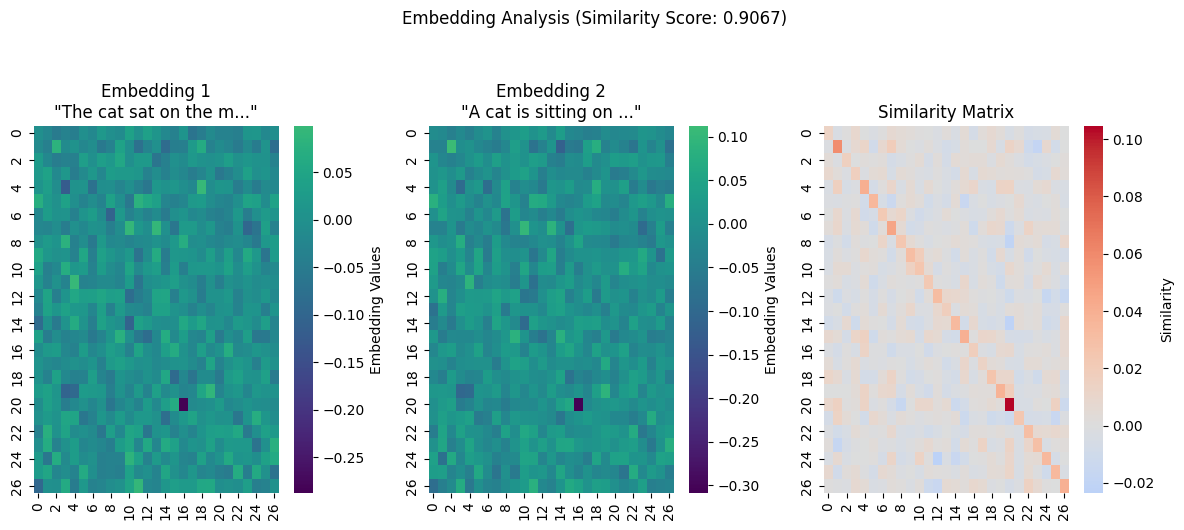

0.90672314

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

def visualize_embeddings(sentence1, sentence2):
    """
    Visualize the relationship between two sentence embeddings using
    multiple visualization techniques.

    Args:
        sentence1 (str): First sentence
        sentence2 (str): Second sentence
    """
    # Get embeddings
    embedding1 = model.encode(sentence1, normalize_embeddings=True)
    embedding2 = model.encode(sentence2, normalize_embeddings=True)
    dimensions = range(len(embedding1))

    # Create figure with subplots
    fig = plt.figure(figsize=(15, 5))


    # Dimension-wise Comparison
    plt.subplot(132)
    plt.plot(dimensions, embedding1,
             label=f'Sentence 1: "{sentence1[:30]}..."',
             alpha=0.7,
             linewidth=1)
    plt.plot(dimensions, embedding2,
             label=f'Sentence 2: "{sentence2[:30]}..."',
             alpha=0.7,
             linewidth=1)
    plt.title('Comparison')
    plt.legend()
    plt.grid(True)

    # 2D PCA Projection
    plt.subplot(133)
    # Combine embeddings and apply PCA
    combined_embeddings = np.vstack([embedding1, embedding2])
    pca = PCA(n_components=2)
    projected = pca.fit_transform(combined_embeddings)

    plt.scatter(projected[0, 0], projected[0, 1], c='blue', label='Sentence 1', s=100)
    plt.scatter(projected[1, 0], projected[1, 1], c='red', label='Sentence 2', s=100)
    plt.plot([projected[0, 0], projected[1, 0]],
             [projected[0, 1], projected[1, 1]],
             'k--', alpha=0.5)
    plt.title('2D PCA Projection')
    plt.legend()
    plt.grid(True)

    # Add overall title and adjust layout
    plt.suptitle(f'Embedding Relationship Analysis\n"{sentence1}" vs "{sentence2}"',
                 fontsize=12, y=1.05)
    plt.tight_layout()

    # Calculate and display similarity score
    similarity = np.dot(embedding1, embedding2)
    print(f"Similarity Score: {similarity:.4f}")

    plt.show()

def plot_embedding_heatmap(sentence1, sentence2):
    """
    Create an improved heatmap visualization of embedding similarities.

    Args:
        sentence1 (str): First sentence
        sentence2 (str): Second sentence
    """
    # Get embeddings
    embedding1 = model.encode(sentence1, normalize_embeddings=True)
    embedding2 = model.encode(sentence2, normalize_embeddings=True)

    # Reshape embeddings to 2D matrices for better visualization
    size = int(np.sqrt(len(embedding1)))
    matrix1 = embedding1[:size*size].reshape(size, size)
    matrix2 = embedding2[:size*size].reshape(size, size)

    # Create similarity matrix
    similarity_matrix = np.dot(matrix1, matrix2.T)

    # Plot setup
    plt.figure(figsize=(12, 5))

    # Create subplots for both individual embeddings and their similarity
    plt.subplot(131)
    sns.heatmap(matrix1,
                cmap='viridis',
                center=0,
                cbar_kws={'label': 'Embedding Values'})
    plt.title(f'Embedding 1\n"{sentence1[:20]}..."')

    plt.subplot(132)
    sns.heatmap(matrix2,
                cmap='viridis',
                center=0,
                cbar_kws={'label': 'Embedding Values'})
    plt.title(f'Embedding 2\n"{sentence2[:20]}..."')

    plt.subplot(133)
    sns.heatmap(similarity_matrix,
                cmap='coolwarm',
                center=0,
                cbar_kws={'label': 'Similarity'})
    plt.title('Similarity Matrix')

    # Calculate overall similarity score
    similarity = np.dot(embedding1, embedding2)

    # Add overall title with similarity score
    plt.suptitle(f'Embedding Analysis (Similarity Score: {similarity:.4f})',
                 y=1.05)

    plt.tight_layout()
    plt.show()

    return similarity

visualize_embeddings(sentence1, sentence2)
plot_embedding_heatmap(sentence1, sentence2)

embed chunks

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

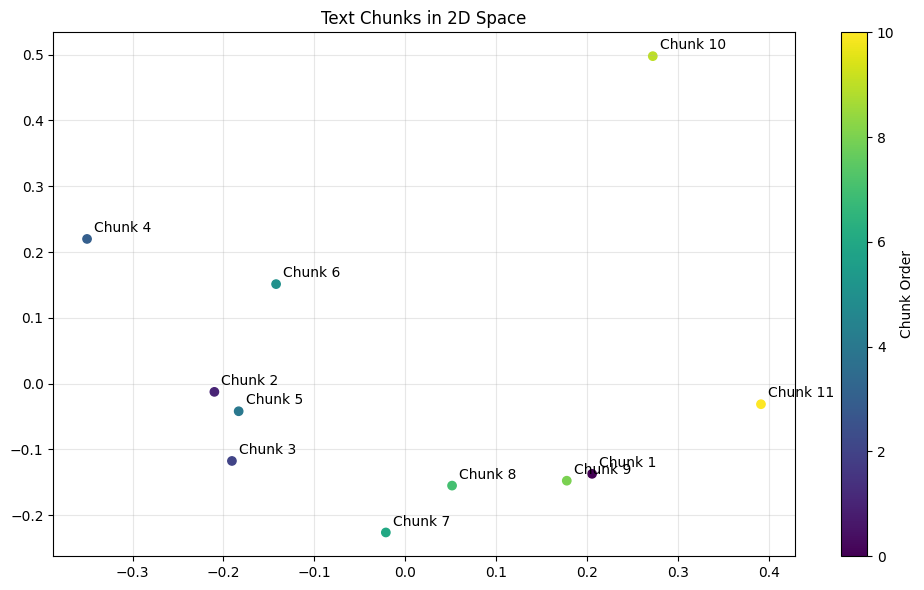

In [12]:
def simple_visualize_chunks(chunks):
    """
    Create a simple 2D visualization of text chunk relationships.

    Args:
        chunks (list): List of text chunks to visualize
    """
    # Get embeddings and reduce dimensions
    embeddings = model.encode(chunks, normalize_embeddings=True, show_progress_bar=True)
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeddings)

    # Create plot
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], c=range(len(chunks)), cmap='viridis')

    # Add labels
    for i, (x, y) in enumerate(reduced):
        plt.annotate(f"Chunk {i+1}", (x, y), xytext=(5, 5), textcoords='offset points')

    plt.title("Text Chunks in 2D Space")
    plt.grid(True, alpha=0.3)
    plt.colorbar(label='Chunk Order')

    plt.tight_layout()
    plt.show()

# Example usage:
# chunked_data = ["hello", "bird", "how are you doing" , "king"]
simple_visualize_chunks(chunked_data)